In [1]:
import sys

path_append = "../../" # Go up one directory from where you are.
sys.path.append(path_append) 

import torch
from tools.config.ml_config import MLConfig
from tools.config.data_config import DataConfig
from nn.utils.init_layer import set_random_seed
set_random_seed(0)

In [2]:
from torchvision import datasets, transforms

attribute_indices = torch.tensor([4, 9])

transform_mnist = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)),  
])

trainset = datasets.FashionMNIST(root='../data/fmnist', train=True, transform=transform_mnist, download=True)
testset = datasets.FashionMNIST(root='../data/fmnist', train=False, transform=transform_mnist, download=True)
num_classes = len(trainset.classes)


c:\Users\CCNets-team\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


100%|██████████| 26421880/26421880 [00:05<00:00, 4612866.73it/s]


Extracting ../data/fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data/fmnist\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 113225.51it/s]


Extracting ../data/fmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data/fmnist\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:06<00:00, 654274.35it/s] 


Extracting ../data/fmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data/fmnist\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5141018.33it/s]

Extracting ../data/fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/fmnist\FashionMNIST\raw



In [3]:
#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_config = MLConfig(model_name = 'resnet')
ml_config.model.num_layers = 4
ml_config.model.d_model = 128

obs_shape = trainset[0][0].shape

print(f"Input shape: {obs_shape}")
print(f"Label shape: {num_classes}")

print(f"Total number of samples in trainset: {len(trainset)}")


# search trainset indices where the attribute from 0 to num_classes-1 is present for one each class.
indices = []
for i in range(num_classes):
    indices.append(torch.where(trainset.targets == i)[0][0].item())
data_config = DataConfig(dataset_name = 'fashion_mnist', task_type='multi_class_classification', obs_shape=obs_shape, label_size= num_classes,
                         show_image_indices=indices)

Input shape: torch.Size([1, 28, 28])
Label shape: 10
Total number of samples in trainset: 60000


In [4]:
# Custom dataset class for CelebA dataset
class FashionMnist(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        X, y = self.dataset[index]  # Get the image and label at the specified index
        y = torch.tensor(y, dtype=torch.long).unsqueeze(0) # Convert the label to a tensor
        return X, y 
    
    def __len__(self):
        return len(self.dataset) # Return the size of the dataset
        
trainset = FashionMnist(trainset)
testset = FashionMnist(testset)

In [5]:
from causal_learning import CausalLearning

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the CausalLearning class with the training configuration, data configuration, device, and use_print and use_wandb flags
causal_learning = CausalLearning(ml_config, data_config, device, use_print=True, use_wandb=True)

c:\Users\CCNets-team\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\CCNets-team\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainer Name: causal_trainer


ModelConfig Parameters:


,d_model,dropout,model_name,num_layers,use_seq_input
0,128,0.05,resnet,4,False


TrainConfig Parameters:


,batch_size,error_function,max_seq_len,min_seq_len,num_epoch
0,64,mse,None,None,100


OptimConfig Parameters:


,clip_grad_range,decay_rate_100k,learning_rate,max_grad_norm,scheduler_type
0,None,0.05,0.001,1.0,exponential


DataConfig Parameters:


,dataset_name,task_type,obs_shape,label_size,explain_size,show_image_indices
0,fashion_mnist,multi_class_classification,"(1, 28, 28)",10,None,"[1, 16, 5, 3, 19, 8, 18, 6, 23, 0]"



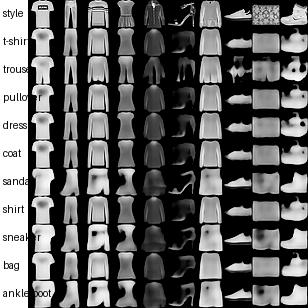

[31/100][153/937][Time 27.22]
Unified LR across all optimizers: 0.0004169521628291519
=====================Train Metrics=======================
CCNet:  Three Resnet
Inf: 0.0024	Gen: 0.0902	Rec: 0.0901	E: 0.0000	R: 0.0000	P: 0.0380

accuracy: 0.9492
precision: 0.9518
recall: 0.9485
f1_score: 0.9494

=====================Eval Metrics========================
accuracy: 0.9258
precision: 0.9208
recall: 0.9245
f1_score: 0.9205



In [6]:
causal_learning.train(trainset, testset)